In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install opensmile
!pip install librosa
!pip install librosa==0.10.2.post1 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# RTFER data import
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Download the correct dataset using the updated identifier
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 695MB/s]


In [ ]:
# FER data import
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content/fer2013/')
zip_ref.close()

In [ ]:
# SIER data import
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Major_Project/SIER_zips/Crema-D_AUDIOWAV.zip', 'r')
zip_ref.extractall('/content/Crema-D_AUDIOWAV/')
zip_ref.close()

In [ ]:
# RTFER Preprocessing for Custom CNN with 6 Emotions (48x48 RGB)
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Emotion label mapping (surprise removed)
emotion_labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'neutral'
}
emotion_map = {v: i for i, v in enumerate(emotion_labels.values())}

data, labels = [], []
dataset_path = '/content/fer2013/train'

for emotion_folder in os.listdir(dataset_path):
    if emotion_folder.lower() == 'surprise':
        continue
    emotion_path = os.path.join(dataset_path, emotion_folder)
    for img_file in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (48, 48))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            data.append(img / 255.0)
            labels.append(emotion_map[emotion_folder.lower()])

X = np.array(data)
y = to_categorical(np.array(labels), num_classes=6)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Preprocessing Complete: ", X_train.shape, y_train.shape)


✅ Data Preprocessing Complete:  (20430, 48, 48, 3) (20430, 6)


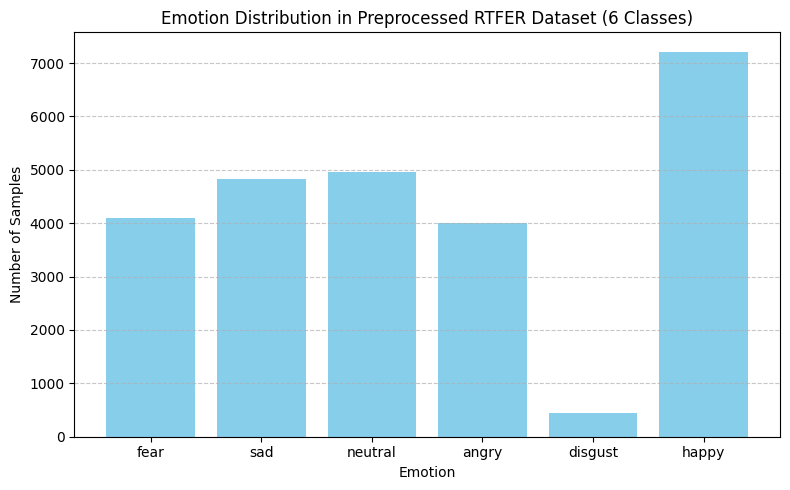

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count frequency of each emotion label from original (integer) labels
emotion_counts = Counter(labels)

# Map indices back to emotion names for display
emotion_names = [list(emotion_map.keys())[list(emotion_map.values()).index(i)] for i in emotion_counts.keys()]
counts = list(emotion_counts.values())

# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(emotion_names, counts, color='skyblue')
plt.title('Emotion Distribution in Preprocessed RTFER Dataset (6 Classes)')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# RTFER Training using Custom CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Build a deep CNN for 48x48 RGB emotion detection
def build_custom_rtfer_model(input_shape=(48, 48, 3), num_classes=6):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Compile model
model = build_custom_rtfer_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('final_rtfer_custom_cnn_model50epochs.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=50,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2233 - loss: 2.7151
Epoch 1: val_accuracy improved from -inf to 0.19440, saving model to final_rtfer_custom_cnn_model50epochs.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.2233 - loss: 2.7133 - val_accuracy: 0.1944 - val_loss: 2.3095
Epoch 2/50
318/320 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2589 - loss: 1.6981
Epoch 2: val_accuracy improved from 0.19440 to 0.31382, saving model to final_rtfer_custom_cnn_model50epochs.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.2590 - loss: 1.6980 - val_accuracy: 0.3138 - val_loss: 1.7431
Epoch 3/50
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2805 - loss: 1.6574
Epoch 3: val_accuracy improved from 0.31382 to 0.33771, saving model to final_rtfer_custom_cnn_model50epochs.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.2806 - loss: 1.6573 - val_accuracy: 0.3377 - val_loss: 1.8169
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from google.colab import files

# Download models to local machine
files.download("final_rtfer_custom_cnn_model50epochs.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

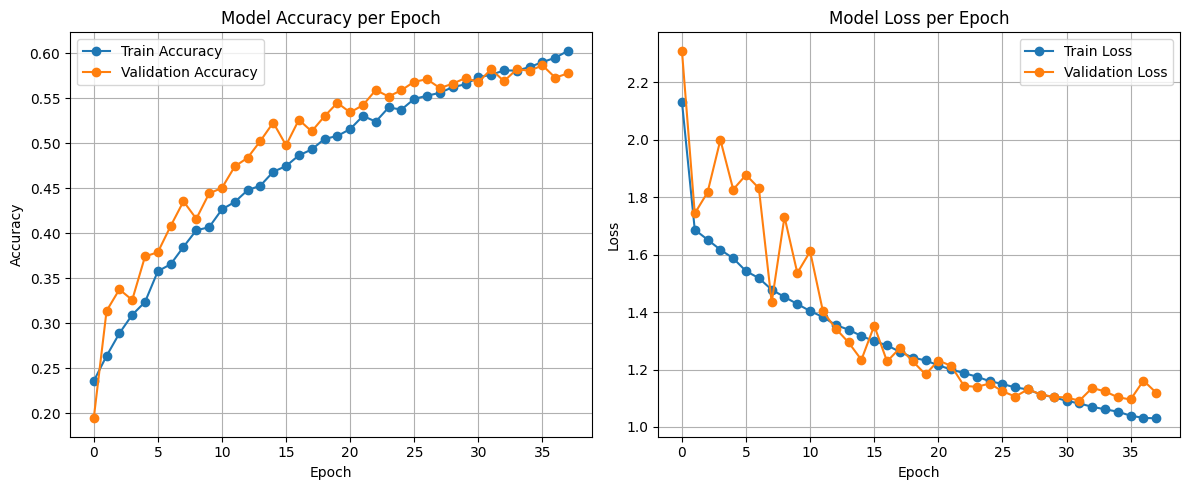

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


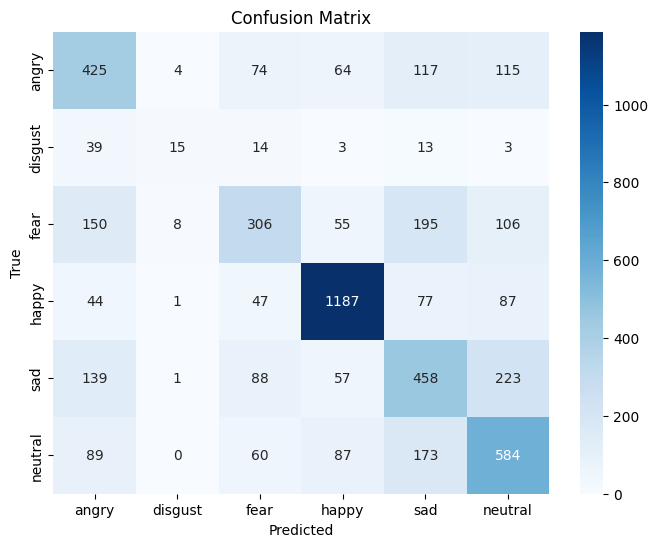

Classification Report (F1 Scores):
              precision    recall  f1-score   support

       angry       0.48      0.53      0.50       799
     disgust       0.52      0.17      0.26        87
        fear       0.52      0.37      0.43       820
       happy       0.82      0.82      0.82      1443
         sad       0.44      0.47      0.46       966
     neutral       0.52      0.59      0.55       993

    accuracy                           0.58      5108
   macro avg       0.55      0.49      0.50      5108
weighted avg       0.58      0.58      0.58      5108

✅ Z-score shape: (20430, 6912)
✅ 99.99% of pixel features are within acceptable z-score range (±3)


In [ ]:
# Performance Metrics
# Epochs vs accuracy and loss graph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



#Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Emotion labels (same order as one-hot encoded)
emotion_labels_list = list(emotion_labels.values())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels_list,
            yticklabels=emotion_labels_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



# F 1 Score
from sklearn.metrics import classification_report

print("Classification Report (F1 Scores):")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels_list))



# Z score
from scipy.stats import zscore

z_scores = zscore(X_train.reshape(X_train.shape[0], -1), axis=0)
print("Z-score shape:", z_scores.shape)

# Check if mostly within [-3, 3]
z_pass_rate = np.mean((z_scores > -3) & (z_scores < 3)) * 100
print(f"{z_pass_rate:.2f}% of pixel features are within acceptable z-score range (±3)")

In [ ]:
# SIER Data Labelling
import os
sierdata_path = '/content/Crema-D_AUDIOWAV/'
if not os.path.isdir(sierdata_path):
    print(f"Error: '{sierdata_path}' is not a valid directory or does not exist.")


files_count = {"NEU":0, "DIS":0, "ANG":0, "HAP":0, "FEA":0, "SAD":0}
try:
        # List all entries in the directory
        for entry_name in os.listdir(sierdata_path):
            # Construct the full path to the entry
            full_path = os.path.join(sierdata_path, entry_name)
            # Check if the entry is a file (and not a directory)
            if os.path.isfile(full_path):
                # print("here")
                if full_path[-10:-7] == "NEU":
                  files_count["NEU"] += 1
                elif full_path[-10:-7] == "DIS":
                  files_count["DIS"] += 1
                elif full_path[-10:-7] == "ANG":
                  files_count["ANG"] += 1
                elif full_path[-10:-7] == "HAP":
                  files_count["HAP"] += 1
                elif full_path[-10:-7] == "FEA":
                  files_count["FEA"] += 1
                elif full_path[-10:-7] == "SAD":
                  files_count["SAD"] += 1

except PermissionError:
    print(f"Error: Permission denied to access '{sierdata_path}'.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print(files_count)

{'NEU': 1087, 'DIS': 1271, 'ANG': 1271, 'HAP': 1271, 'FEA': 1271, 'SAD': 1270}


<ipython-input-15-6fec67a97729>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Emotion', y='Count', data=df, palette='viridis')


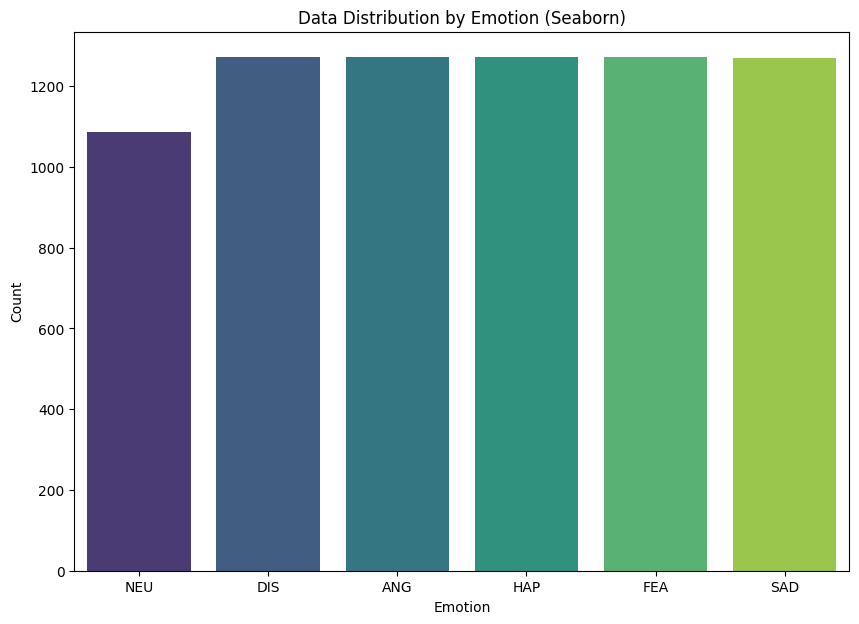

In [ ]:
# Visualize Class Distribution for SIER

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convert dictionary to a Pandas Series, then to a DataFrame
df = pd.Series(files_count).reset_index()
df.columns = ['Emotion', 'Count'] # Rename columns

plt.figure(figsize=(10, 7))
sns.barplot(x='Emotion', y='Count', data=df, palette='viridis')

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Data Distribution by Emotion (Seaborn)')
plt.show()

In [ ]:
# Import necessary libraries (Optional code) - accuracy - 46.810
import os
import librosa
import numpy as np
import torch
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import opensmile
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from sklearn.utils import class_weight

# Dataset Path
sier_audio_path = "/content/Crema-D_AUDIOWAV"

# Emotion Mapping
emotion_map = {
    "NEU": "Neutral",
    "DIS": "Disgust",
    "ANG": "Angry",
    "HAP": "Happy",
    "FEA": "Fear",
    "SAD": "Sad"
}

# Load Models
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# OpenSMILE
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals
)

# Feature Extraction
X_combined = []
y_labels = []
files = [f for f in os.listdir(sier_audio_path) if f.endswith('.wav')]
print(f"Found {len(files)} audio files to process...\n")

for idx, file in enumerate(tqdm(files)):
    emotion_code = file[-10:-7]
    if emotion_code in emotion_map:
        try:
            y, sr = librosa.load(os.path.join(sier_audio_path, file), sr=16000)
            input_values = processor(y, sampling_rate=sr, return_tensors="pt", padding=True).to(device)
            with torch.no_grad():
                wav2vec_features = model(**input_values).last_hidden_state.mean(dim=1).detach().cpu().numpy().flatten()
            smile_features = smile.process_signal(y, sr)
            if not smile_features.empty:
                smile_vector = smile_features.values.flatten()
                combined_vector = np.concatenate([wav2vec_features, smile_vector])
                X_combined.append(combined_vector)
                y_labels.append(emotion_map[emotion_code])
        except Exception as e:
            print(f"Skipping {file}: {e}")

# Prepare data
X_sier = np.array(X_combined)
y_sier = np.array(y_labels)

# Normalize features
scaler = StandardScaler()
X_sier = scaler.fit_transform(X_sier)

# Label Encoding
y_encoded = LabelEncoder().fit_transform(y_sier)
y_sier_categorical = to_categorical(y_encoded)

# Train-Val Split
X_sier_train, X_sier_val, y_sier_train, y_sier_val = train_test_split(
    X_sier, y_sier_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

# Compute class weights
y_train_labels = np.argmax(y_sier_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

# Expand dims for 1D-CNN
X_sier_train_cnn = np.expand_dims(X_sier_train, axis=-1)
X_sier_val_cnn = np.expand_dims(X_sier_val, axis=-1)

# Deep 1D-CNN Model
sier_model = models.Sequential([
    layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_sier_train_cnn.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.Conv1D(512, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(y_sier_train.shape[1], activation='softmax')
])

# Compile
sier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = callbacks.ModelCheckpoint("best_model_sier_50epochs.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train Model
history_sier = sier_model.fit(
    X_sier_train_cnn, y_sier_train,
    validation_data=(X_sier_val_cnn, y_sier_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weights_dict
)

print("SIER model training complete and best model saved as best_model_sier_50epochs.keras")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

🔍 Found 7442 audio files to process...



100%|██████████| 7442/7442 [16:28<00:00,  7.53it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
183/186 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2406 - loss: 1.8075
Epoch 1: val_accuracy improved from -inf to 0.14641, saving model to best_model_sier_50epochs.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.2413 - loss: 1.8054 - val_accuracy: 0.1464 - val_loss: 2.9411 - learning_rate: 0.0010
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3407 - loss: 1.5854
Epoch 2: val_accuracy improved from 0.14641 to 0.18402, saving model to best_model_sier_50epochs.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3407 - loss: 1.5853 - val_accuracy: 0.1840 - val_loss: 1.8080 - learning_rate: 0.0010
Epoch 3/50
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3668 - loss: 1.5376
Epoch 3: val_accuracy improved from 0.18402 to 0.36266, saving model to best_model_sier_50epochs.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3668 - loss: 1.5376 - val_accuracy: 0.3627 - val_loss: 1.5491 - learning_rate: 0.0010
Epoch

In [ ]:
# ✅ SIER Optimized Training using Wav2Vec + PCA + MLP

import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, callbacks
from sklearn.utils import class_weight

# Assume X_combined and y_labels already exist from preprocessing
X_sier = np.array(X_combined)
y_sier = np.array(y_labels)

# Standardize features
scaler = StandardScaler()
X_sier_scaled = scaler.fit_transform(X_sier)

# Dimensionality Reduction with PCA
pca = PCA(n_components=300)
X_sier_pca = pca.fit_transform(X_sier_scaled)

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_sier)
y_sier_categorical = to_categorical(y_encoded)

# Train/Validation split
X_sier_train, X_sier_val, y_sier_train, y_sier_val = train_test_split(
    X_sier_pca, y_sier_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

# Class weights
train_labels = np.argmax(y_sier_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

# Optimized MLP Model
sier_model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_sier_train.shape[1],)),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(y_sier_train.shape[1], activation='softmax')
])

# Compile
sier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = callbacks.ModelCheckpoint("best_model_sier_pca_mlp.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-5)

# Train
history_sier = sier_model.fit(
    X_sier_train, y_sier_train,
    validation_data=(X_sier_val, y_sier_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

print("\n Optimized SIER MLP model training complete.")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


183/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3255 - loss: 1.7758
Epoch 1: val_accuracy improved from -inf to 0.52787, saving model to best_model_sier_pca_mlp.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3269 - loss: 1.7708 - val_accuracy: 0.5279 - val_loss: 1.2349 - learning_rate: 0.0010
Epoch 2/50
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5207 - loss: 1.2558
Epoch 2: val_accuracy improved from 0.52787 to 0.57555, saving model to best_model_sier_pca_mlp.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5208 - loss: 1.2556 - val_accuracy: 0.5756 - val_loss: 1.0993 - learning_rate: 0.0010
Epoch 3/50
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5992 - loss: 1.0784
Epoch 3: val_accuracy improved from 0.57555 to 0.61921, saving model to best_model_sier_pca_mlp.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5992 - loss: 1.0782 - val_accuracy: 0.6192 - val_loss: 1.0260 - learning_rate: 0.0010
Epoch 4/50
181/186 ━━━━━━━━

In [ ]:
from google.colab import files

# Download models to local machine
files.download("best_model_sier_50epochs.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

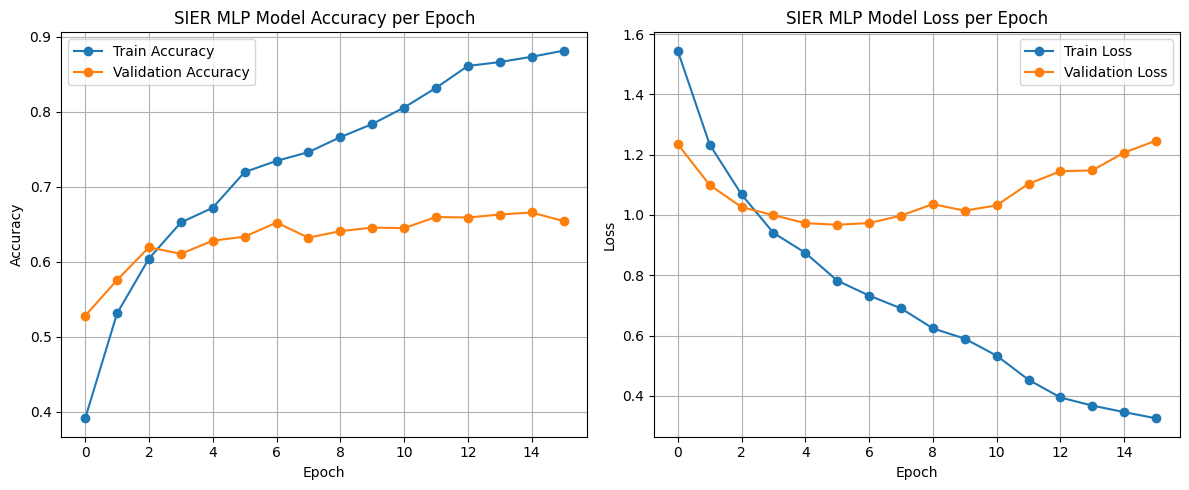

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


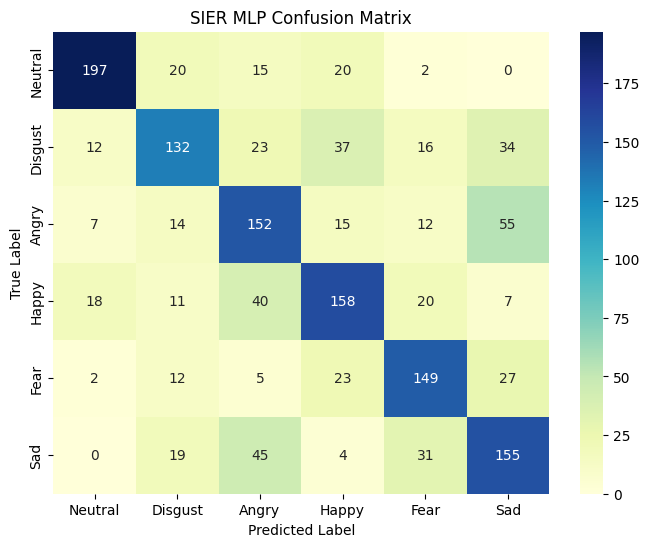

SIER MLP Classification Report:
              precision    recall  f1-score   support

     Neutral       0.83      0.78      0.80       254
     Disgust       0.63      0.52      0.57       254
       Angry       0.54      0.60      0.57       255
       Happy       0.61      0.62      0.62       254
        Fear       0.65      0.68      0.67       218
         Sad       0.56      0.61      0.58       254

    accuracy                           0.63      1489
   macro avg       0.64      0.63      0.64      1489
weighted avg       0.64      0.63      0.63      1489

✅ 99.42% of features in SIER training set are within ±3 z-score range


In [ ]:
# Accuracy vs. Loss Curve (Epoch-wise)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_sier.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_sier.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('SIER MLP Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_sier.history['loss'], label='Train Loss', marker='o')
plt.plot(history_sier.history['val_loss'], label='Validation Loss', marker='o')
plt.title('SIER MLP Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions from model
y_pred_sier = sier_model.predict(X_sier_val)
y_pred_classes_sier = np.argmax(y_pred_sier, axis=1)
y_true_classes_sier = np.argmax(y_sier_val, axis=1)

# Class labels
sier_emotions = ['Neutral', 'Disgust', 'Angry', 'Happy', 'Fear', 'Sad']

# Confusion matrix
conf_mat_sier = confusion_matrix(y_true_classes_sier, y_pred_classes_sier)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_sier, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=sier_emotions, yticklabels=sier_emotions)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SIER MLP Confusion Matrix")
plt.show()


# Classification Report (F1 Score, Precision, Recall)
from sklearn.metrics import classification_report

print("SIER MLP Classification Report:")
print(classification_report(y_true_classes_sier, y_pred_classes_sier, target_names=sier_emotions))



# Z-score analysis for feature normalization health check
from scipy.stats import zscore

# Z-score analysis on training data (PCA-reduced features)
z_scores_sier = zscore(X_sier_train, axis=0)

# Check how many values fall within the ±3 z-score range
within_range = ((z_scores_sier > -3) & (z_scores_sier < 3)).mean() * 100
print(f" {within_range:.2f}% of features in SIER training set are within ±3 z-score range")

